# LSTM Autoencoder for Time Series - Unsupervised Learning

This notebook implements an LSTM-based Autoencoder for time series analysis without labels. It's useful for:
- **Anomaly Detection**: Identify unusual patterns in time series data
- **Dimensionality Reduction**: Compress time series into latent representations
- **Unsupervised Learning**: No labels required, learns patterns automatically

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Generate Sample Time Series Data

In [3]:
def generate_time_series_data(n_samples=1000, n_timesteps=50, n_features=1, anomaly_ratio=0.05):
    """
    Generate synthetic time series data with optional anomalies
    
    Args:
        n_samples: Number of time series sequences
        n_timesteps: Length of each sequence (time steps)
        n_features: Number of features per time step
        anomaly_ratio: Ratio of sequences containing anomalies
    
    Returns:
        data: Time series data of shape (n_samples, n_timesteps, n_features)
        anomaly_labels: Binary labels indicating anomalies (for evaluation)
    """
    data = []
    anomaly_labels = []
    
    for i in range(n_samples):
        # Normal time series: sinusoidal pattern with noise
        t = np.linspace(0, 4*np.pi, n_timesteps)
        normal_series = np.sin(t) * np.exp(-t/(4*np.pi))
        
        # Add random noise
        noise = np.random.normal(0, 0.1, (n_timesteps, n_features))
        series = normal_series.reshape(-1, 1) + noise
        
        # Add anomalies with certain probability
        is_anomaly = np.random.rand() < anomaly_ratio
        if is_anomaly:
            # Insert anomalous pattern (spikes)
            anomaly_idx = np.random.randint(10, n_timesteps-10)
            series[anomaly_idx:anomaly_idx+5, 0] += np.random.uniform(2, 4)
        
        data.append(series)
        anomaly_labels.append(is_anomaly)
    
    return np.array(data), np.array(anomaly_labels)

# Generate data
print("Generating time series data...")
X, anomaly_labels = generate_time_series_data(n_samples=100_000, n_timesteps=50, n_features=40, anomaly_ratio=0.1)

print(f"Data shape: {X.shape}")
print(f"Anomaly samples: {np.sum(anomaly_labels)} out of {len(anomaly_labels)}")

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

print(f"Data normalized to range [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")

Generating time series data...
Data shape: (100000, 50, 40)
Anomaly samples: 9762 out of 100000
Data shape: (100000, 50, 40)
Anomaly samples: 9762 out of 100000
Data normalized to range [0.0000, 1.0000]
Data normalized to range [0.0000, 1.0000]


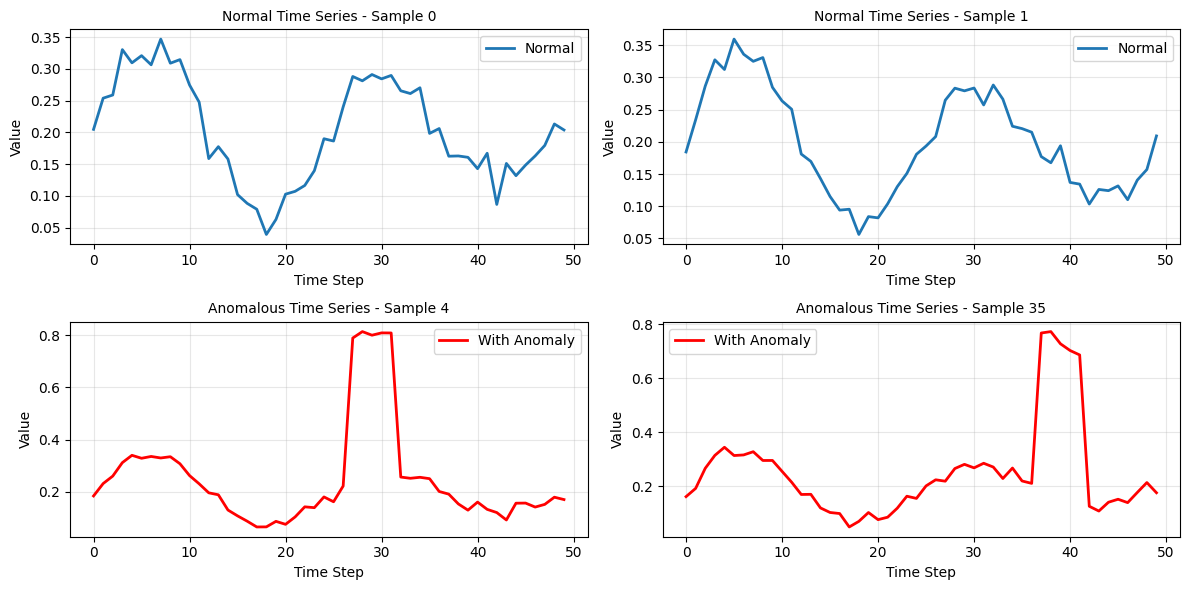

Data preview completed!


In [4]:
# Visualize sample time series
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for idx, ax in enumerate(axes.flat):
    if idx < 2:
        # Normal samples
        ax.plot(X_scaled[idx, :, 0], linewidth=2, label='Normal')
        ax.set_title(f'Normal Time Series - Sample {idx}', fontsize=10)
    else:
        # Anomalous samples
        anomaly_idx = np.where(anomaly_labels)[0][idx-2]
        ax.plot(X_scaled[anomaly_idx, :, 0], linewidth=2, color='red', label='With Anomaly')
        ax.set_title(f'Anomalous Time Series - Sample {anomaly_idx}', fontsize=10)
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

print("Data preview completed!")

## 2. Build LSTM Autoencoder Architecture

The model consists of:
- **Encoder**: Compresses the time series into a latent vector using LSTM layers
- **Decoder**: Reconstructs the time series from the latent vector using inverse LSTM layers
- **Loss Function**: Reconstruction error (MSE) - measures how well the model learns normal patterns

In [5]:
def build_lstm_autoencoder(timesteps, features, encoding_dim=32):
    """
    Build an LSTM Autoencoder model for time series
    
    Args:
        timesteps: Number of time steps in each sequence
        features: Number of features per time step
        encoding_dim: Dimension of the latent representation
    
    Returns:
        autoencoder: Full autoencoder model
        encoder: Encoder model to get latent representations
        decoder: Decoder model to reconstruct from latents
    """
    
    # ============ ENCODER ============
    inputs = keras.Input(shape=(timesteps, features))
    
    # LSTM encoder layers with progressively smaller dimensionality
    encoded = layers.LSTM(64, activation='relu', return_sequences=True)(inputs)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.LSTM(32, activation='relu', return_sequences=True)(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.LSTM(encoding_dim, activation='relu', return_sequences=False)(encoded)
    
    # Create encoder model
    encoder = Model(inputs, encoded, name='encoder')
    
    # ============ DECODER ============
    # Repeat latent vector for all time steps
    decoded = layers.RepeatVector(timesteps)(encoded)
    
    # LSTM decoder layers with progressively larger dimensionality
    decoded = layers.LSTM(encoding_dim, activation='relu', return_sequences=True)(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    decoded = layers.LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    decoded = layers.LSTM(64, activation='relu', return_sequences=True)(decoded)
    
    # Output layer with linear activation to match input range
    decoded = layers.TimeDistributed(layers.Dense(features, activation='linear'))(decoded)
    
    # Create full autoencoder model
    autoencoder = Model(inputs, decoded, name='lstm_autoencoder')
    
    return autoencoder, encoder, inputs, encoded

# Build model
timesteps = X_scaled.shape[1]  # 50
features = X_scaled.shape[2]   # 1
encoding_dim = 32

print("Building LSTM Autoencoder...")
autoencoder, encoder, inputs, encoded = build_lstm_autoencoder(
    timesteps=timesteps, 
    features=features, 
    encoding_dim=encoding_dim
)

# Compile model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("\nAutoencoder Architecture:")
autoencoder.summary()

Building LSTM Autoencoder...

Autoencoder Architecture:

Autoencoder Architecture:


Model: "lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 64)         │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 40)         │         2,600 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the Autoencoder (Unsupervised Learning)

The model is trained on both normal and anomalous data, learning to reconstruct the normal patterns. High reconstruction error indicates anomalies.

In [6]:
# Split data for training and validation (no labels used)
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Train the autoencoder
print("\nTraining LSTM Autoencoder...")
history = autoencoder.fit(
    X_train, X_train,  # Train to reconstruct the input (unsupervised)
    epochs=50,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)

print("Training completed!")

Training set size: 80000
Validation set size: 20000

Training LSTM Autoencoder...
Epoch 1/50
Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 90s 29ms/step - loss: 0.0194 - val_loss: 0.0017
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 90s 29ms/step - loss: 0.0194 - val_loss: 0.0017
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - loss: 0.0017 - val_loss: 0.0017
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/50
   1/2500 ━━━━━━━━━━━━━━━━━━━━ 1:47 43ms/step - loss: 0.0017Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━

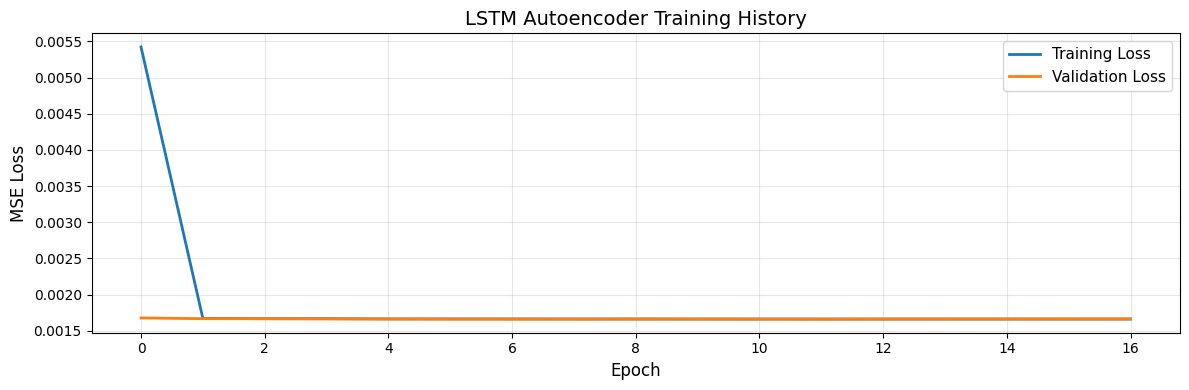

Best validation loss: 0.001662


In [7]:
# Plot training history
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(history.history['loss'], label='Training Loss', linewidth=2)
axes.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes.set_xlabel('Epoch', fontsize=12)
axes.set_ylabel('MSE Loss', fontsize=12)
axes.set_title('LSTM Autoencoder Training History', fontsize=14)
axes.legend(fontsize=11)
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation loss: {min(history.history['val_loss']):.6f}")

## 4. Anomaly Detection using Reconstruction Error

In [8]:
# Make predictions on full dataset
X_predictions = autoencoder.predict(X_scaled)

# Calculate reconstruction errors (Mean Squared Error per sample)
reconstruction_errors = np.mean(np.square(X_scaled - X_predictions), axis=(1, 2))

print(f"Reconstruction Error Statistics:")
print(f"  Mean: {np.mean(reconstruction_errors):.6f}")
print(f"  Std Dev: {np.std(reconstruction_errors):.6f}")
print(f"  Min: {np.min(reconstruction_errors):.6f}")
print(f"  Max: {np.max(reconstruction_errors):.6f}")

# Define anomaly threshold (e.g., 95th percentile)
threshold_percentile = 95
anomaly_threshold = np.percentile(reconstruction_errors, threshold_percentile)
predicted_anomalies = reconstruction_errors > anomaly_threshold

print(f"\nAnomaly Threshold (95th percentile): {anomaly_threshold:.6f}")
print(f"Predicted anomalies: {np.sum(predicted_anomalies)} samples")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
Reconstruction Error Statistics:
  Mean: 0.001663
  Std Dev: 0.000214
  Min: 0.001389
  Max: 0.002862

Anomaly Threshold (95th percentile): 0.002213
Predicted anomalies: 5000 samples
Reconstruction Error Statistics:
  Mean: 0.001663
  Std Dev: 0.000214
  Min: 0.001389
  Max: 0.002862

Anomaly Threshold (95th percentile): 0.002213
Predicted anomalies: 5000 samples


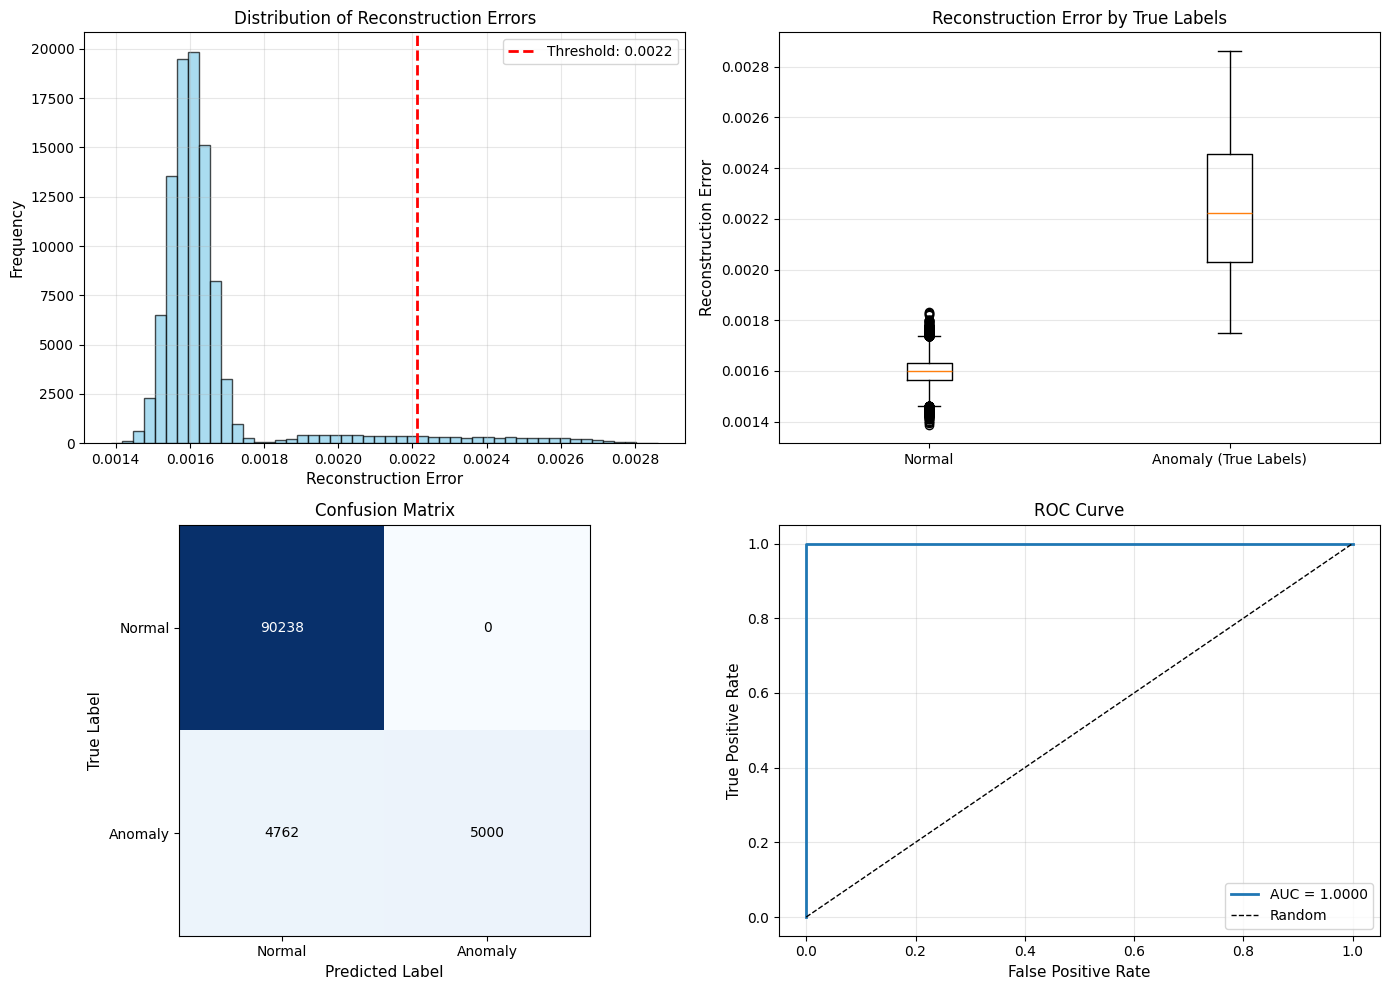


Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97     90238
     Anomaly       1.00      0.51      0.68      9762

    accuracy                           0.95    100000
   macro avg       0.97      0.76      0.83    100000
weighted avg       0.95      0.95      0.95    100000

AUC Score: 1.0000


In [9]:
# Visualize reconstruction errors distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of reconstruction errors
axes[0, 0].hist(reconstruction_errors, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(anomaly_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {anomaly_threshold:.4f}')
axes[0, 0].set_xlabel('Reconstruction Error', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Reconstruction Errors', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot([reconstruction_errors[~anomaly_labels], reconstruction_errors[anomaly_labels]], 
                    labels=['Normal', 'Anomaly (True Labels)'])
axes[0, 1].set_ylabel('Reconstruction Error', fontsize=11)
axes[0, 1].set_title('Reconstruction Error by True Labels', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Comparison of true vs predicted anomalies
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

cm = confusion_matrix(anomaly_labels, predicted_anomalies)
im = axes[1, 0].imshow(cm, interpolation='nearest', cmap='Blues')
axes[1, 0].set_xlabel('Predicted Label', fontsize=11)
axes[1, 0].set_ylabel('True Label', fontsize=11)
axes[1, 0].set_title('Confusion Matrix', fontsize=12)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['Normal', 'Anomaly'])
axes[1, 0].set_yticklabels(['Normal', 'Anomaly'])

# Add text annotations
for i in range(2):
    for j in range(2):
        axes[1, 0].text(j, i, str(cm[i, j]), ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

# ROC Curve
fpr, tpr, _ = roc_curve(anomaly_labels, reconstruction_errors)
auc_score = roc_auc_score(anomaly_labels, reconstruction_errors)
axes[1, 1].plot(fpr, tpr, linewidth=2, label=f'AUC = {auc_score:.4f}')
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1, 1].set_xlabel('False Positive Rate', fontsize=11)
axes[1, 1].set_ylabel('True Positive Rate', fontsize=11)
axes[1, 1].set_title('ROC Curve', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification metrics
print("\nClassification Report:")
print(classification_report(anomaly_labels, predicted_anomalies, target_names=['Normal', 'Anomaly']))
print(f"AUC Score: {auc_score:.4f}")

## 5. Latent Representation Analysis (Dimensionality Reduction)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Latent representation shape: (100000, 32)
Latent encoding dimension: 32

Dimensionality reduction:
  Original: 50 time steps × 40 features = 2000 values
  Compressed: 32 values
  Compression ratio: 62.50x
Latent representation shape: (100000, 32)
Latent encoding dimension: 32

Dimensionality reduction:
  Original: 50 time steps × 40 features = 2000 values
  Compressed: 32 values
  Compression ratio: 62.50x

PCA Variance Explained: 1.0000

PCA Variance Explained: 1.0000


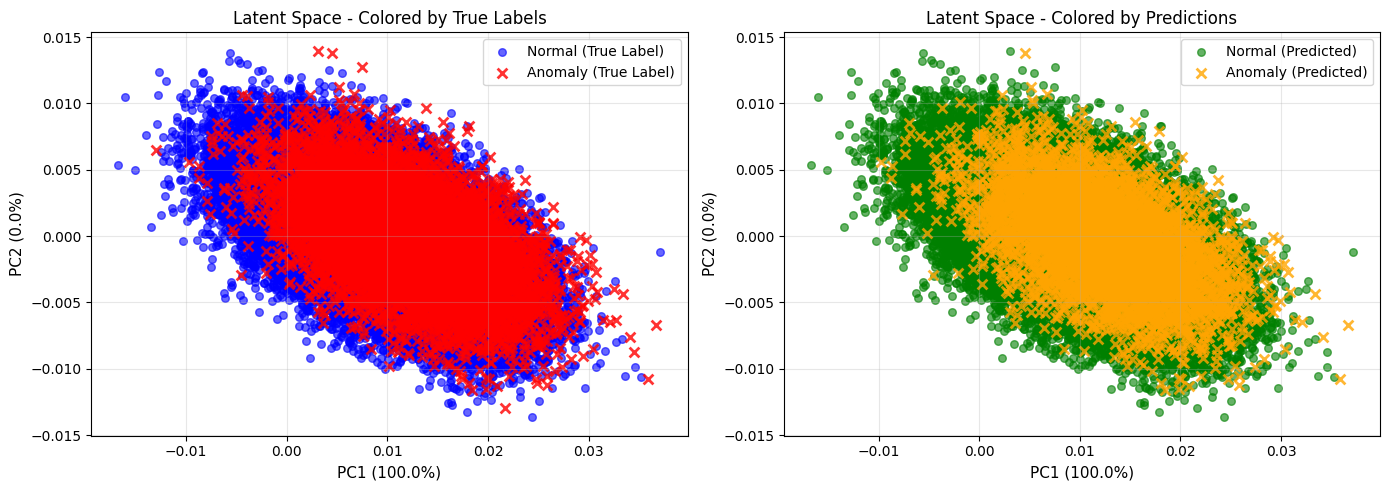

In [10]:
# Get latent representations
latent_representations = encoder.predict(X_scaled)

print(f"Latent representation shape: {latent_representations.shape}")
print(f"Latent encoding dimension: {encoding_dim}")
print(f"\nDimensionality reduction:")
print(f"  Original: {X_scaled.shape[1]} time steps × {X_scaled.shape[2]} features = {X_scaled.shape[1] * X_scaled.shape[2]} values")
print(f"  Compressed: {encoding_dim} values")
print(f"  Compression ratio: {(X_scaled.shape[1] * X_scaled.shape[2]) / encoding_dim:.2f}x")

# Apply PCA for 2D visualization of latent space
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

print(f"\nPCA Variance Explained: {pca.explained_variance_ratio_.sum():.4f}")

# Visualize latent space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latent space colored by true anomalies
scatter1 = axes[0].scatter(latent_2d[~anomaly_labels, 0], latent_2d[~anomaly_labels, 1], 
                           c='blue', alpha=0.6, s=30, label='Normal (True Label)')
scatter2 = axes[0].scatter(latent_2d[anomaly_labels, 0], latent_2d[anomaly_labels, 1], 
                           c='red', alpha=0.8, s=50, marker='x', linewidths=2, label='Anomaly (True Label)')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('Latent Space - Colored by True Labels', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Latent space colored by predicted anomalies
scatter3 = axes[1].scatter(latent_2d[~predicted_anomalies, 0], latent_2d[~predicted_anomalies, 1], 
                           c='green', alpha=0.6, s=30, label='Normal (Predicted)')
scatter4 = axes[1].scatter(latent_2d[predicted_anomalies, 0], latent_2d[predicted_anomalies, 1], 
                           c='orange', alpha=0.8, s=50, marker='x', linewidths=2, label='Anomaly (Predicted)')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1].set_title('Latent Space - Colored by Predictions', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualization of Reconstructions

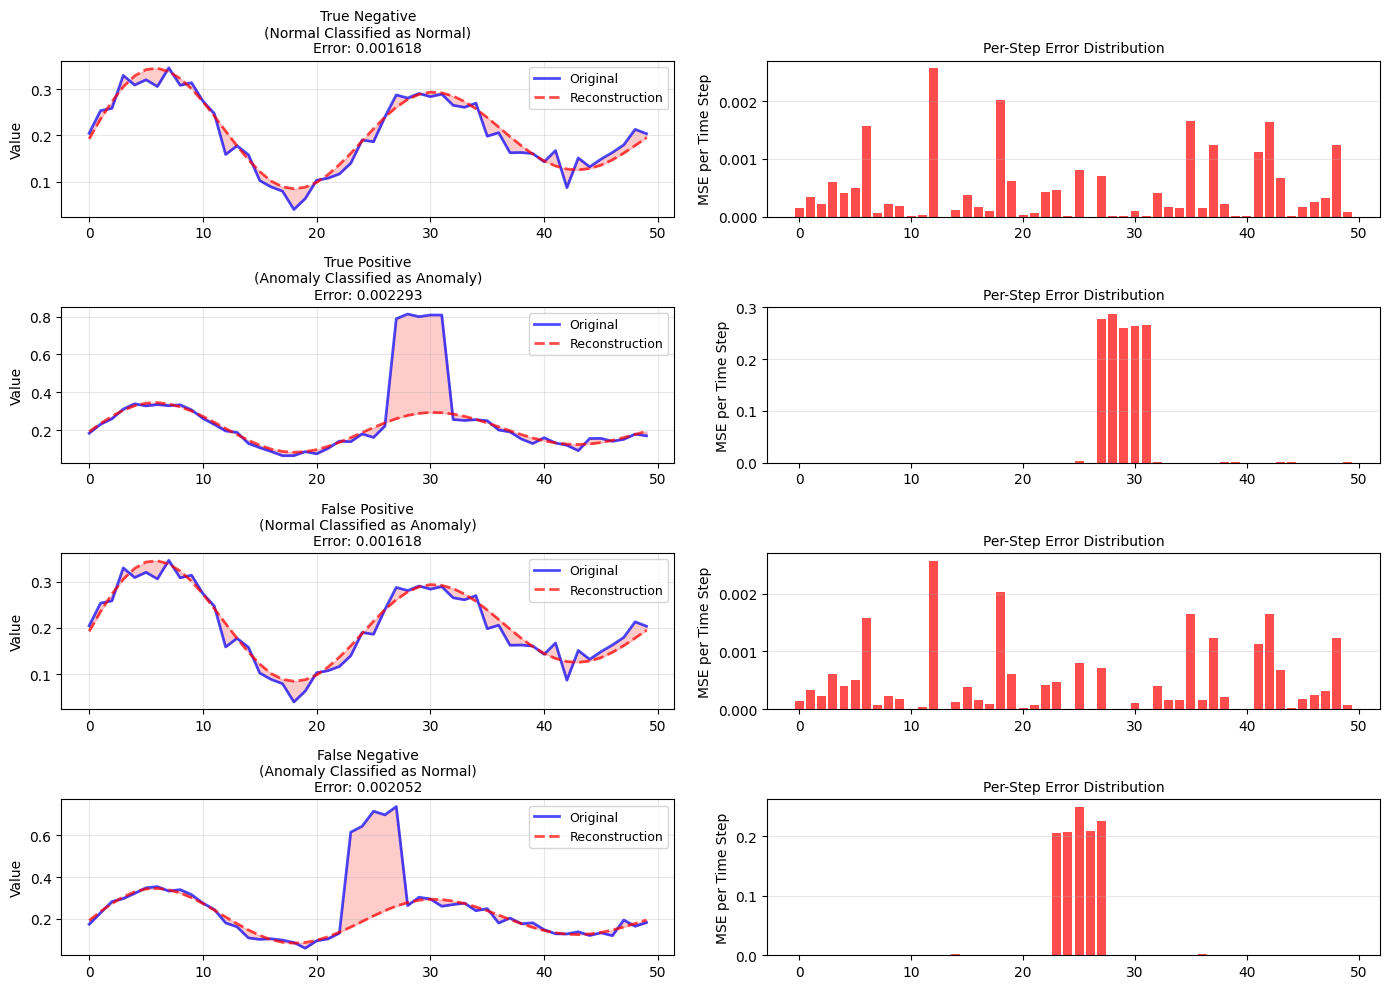

In [11]:
# Visualize normal and anomalous reconstructions
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

# Find examples of different cases
normal_indices = np.where(~anomaly_labels)[0]
anomaly_indices = np.where(anomaly_labels)[0]

# Different prediction outcomes
true_normal_idx = np.where((~anomaly_labels) & (~predicted_anomalies))[0][0]
true_anomaly_idx = np.where((anomaly_labels) & (predicted_anomalies))[0][0]
false_positive_idx = np.where((~anomaly_labels) & (predicted_anomalies))[0][0] if np.any((~anomaly_labels) & (predicted_anomalies)) else true_normal_idx
false_negative_idx = np.where((anomaly_labels) & (~predicted_anomalies))[0][0] if np.any((anomaly_labels) & (~predicted_anomalies)) else true_anomaly_idx

examples = [
    (true_normal_idx, "True Negative\n(Normal Classified as Normal)", 0),
    (true_anomaly_idx, "True Positive\n(Anomaly Classified as Anomaly)", 1),
    (false_positive_idx, "False Positive\n(Normal Classified as Anomaly)", 2),
    (false_negative_idx, "False Negative\n(Anomaly Classified as Normal)", 3),
]

for row, (idx, title, example_num) in enumerate(examples):
    # Original
    axes[row, 0].plot(X_scaled[idx, :, 0], 'b-', linewidth=2, label='Original', alpha=0.7)
    axes[row, 0].plot(X_predictions[idx, :, 0], 'r--', linewidth=2, label='Reconstruction', alpha=0.7)
    axes[row, 0].fill_between(range(len(X_scaled[idx])), X_scaled[idx, :, 0], X_predictions[idx, :, 0], alpha=0.2, color='red')
    axes[row, 0].set_ylabel('Value', fontsize=10)
    axes[row, 0].set_title(f'{title}\nError: {reconstruction_errors[idx]:.6f}', fontsize=10)
    axes[row, 0].legend(fontsize=9)
    axes[row, 0].grid(True, alpha=0.3)
    
    # Reconstruction error at each time step
    step_errors = np.square(X_scaled[idx, :, 0] - X_predictions[idx, :, 0])
    axes[row, 1].bar(range(len(step_errors)), step_errors, color='red', alpha=0.7, width=0.8)
    axes[row, 1].set_ylabel('MSE per Time Step', fontsize=10)
    axes[row, 1].set_title(f'Per-Step Error Distribution', fontsize=10)
    axes[row, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Save and Load the Model

In [12]:
import os
import json
from pathlib import Path

# Create Models directory if it doesn't exist
models_dir = Path('d:/Graduation Project/coreX/AI/Models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save the autoencoder model
model_path = models_dir / 'lstm_autoencoder.h5'
autoencoder.save(str(model_path))
print(f"Autoencoder model saved to: {model_path}")

# Save the encoder model
encoder_path = models_dir / 'lstm_encoder.h5'
encoder.save(str(encoder_path))
print(f"Encoder model saved to: {encoder_path}")

# Save scaler for future data preprocessing
import pickle
scaler_path = models_dir / 'scaler.pkl'
with open(str(scaler_path), 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to: {scaler_path}")

# Save model configuration and parameters
config = {
    'timesteps': timesteps,
    'features': features,
    'encoding_dim': encoding_dim,
    'anomaly_threshold': float(anomaly_threshold),
    'threshold_percentile': threshold_percentile,
}

config_path = models_dir / 'model_config.json'
with open(str(config_path), 'w') as f:
    json.dump(config, f, indent=4)
print(f"Model configuration saved to: {config_path}")

print("\nAll models and configurations saved successfully!")

Autoencoder model saved to: d:/Graduation Project/coreX/AI/Models/lstm_autoencoder.h5
Encoder model saved to: d:/Graduation Project/coreX/AI/Models/lstm_encoder.h5
Scaler saved to: d:/Graduation Project/coreX/AI/Models/scaler.pkl
Model configuration saved to: d:/Graduation Project/coreX/AI/Models/model_config.json

All models and configurations saved successfully!


In [ ]:
# Load the saved model
print("Loading saved models...")
loaded_autoencoder = keras.models.load_model(str(model_path))
loaded_encoder = keras.models.load_model(str(encoder_path))

with open(str(scaler_path), 'rb') as f:
    loaded_scaler = pickle.load(f)

print("Models loaded successfully!")
print(f"\nLoaded autoencoder architecture:")
loaded_autoencoder.summary()

Loading saved models...


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

## 8. Using the Model on New Data

This function shows how to use the trained model for inference on new time series data.

In [ ]:
def detect_anomalies_in_new_data(new_data, model, scaler, threshold, anomaly_threshold_val):
    """
    Detect anomalies in new time series data using the trained autoencoder
    
    Args:
        new_data: New time series data of shape (n_samples, timesteps, features)
        model: Trained autoencoder model
        scaler: Fitted scaler for normalization
        threshold: Reconstruction error threshold
        anomaly_threshold_val: The actual threshold value
    
    Returns:
        predictions: Binary predictions (1 = anomaly, 0 = normal)
        errors: Reconstruction errors for each sample
        reconstructions: Reconstructed data
    """
    # Normalize new data
    new_data_scaled = scaler.transform(new_data.reshape(-1, new_data.shape[-1])).reshape(new_data.shape)
    
    # Get predictions
    reconstructions = model.predict(new_data_scaled)
    
    # Calculate reconstruction errors
    errors = np.mean(np.square(new_data_scaled - reconstructions), axis=(1, 2))
    
    # Make predictions
    predictions = (errors > anomaly_threshold_val).astype(int)
    
    return predictions, errors, reconstructions

# Test on a small sample of new data
new_sample_data = X_scaled[800:810]  # Take 10 samples
predictions, errors, reconstructions = detect_anomalies_in_new_data(
    new_sample_data, 
    loaded_autoencoder, 
    loaded_scaler, 
    anomaly_threshold,
    anomaly_threshold
)

print("New Data Anomaly Detection Results:")
print(f"{'Sample':<8} {'Reconstruction Error':<25} {'Prediction':<15}")
print("-" * 50)
for i, (error, pred) in enumerate(zip(errors, predictions)):
    pred_label = 'ANOMALY' if pred == 1 else 'NORMAL'
    print(f"{i:<8} {error:<25.6f} {pred_label:<15}")

## 9. Model Summary and Key Insights

In [ ]:
print("=" * 70)
print("LSTM AUTOENCODER FOR TIME SERIES - SUMMARY")
print("=" * 70)

print("\n📊 MODEL ARCHITECTURE:")
print(f"  • Input Shape: ({timesteps}, {features})")
print(f"  • Encoder: LSTM (64) → LSTM (32) → LSTM ({encoding_dim})")
print(f"  • Decoder: RepeatVector → LSTM ({encoding_dim}) → LSTM (32) → LSTM (64) → Dense (1)")
print(f"  • Total Parameters: {autoencoder.count_params():,}")

print("\n📈 TRAINING RESULTS:")
print(f"  • Training Samples: {len(X_train)}")
print(f"  • Validation Samples: {len(X_val)}")
print(f"  • Best Validation Loss: {min(history.history['val_loss']):.6f}")
print(f"  • Epochs Trained: {len(history.history['loss'])}")

print("\n🎯 UNSUPERVISED LEARNING (No Labels Required):")
print(f"  • The model learned from time series data without labels")
print(f"  • It captures normal patterns in the latent space")
print(f"  • Deviations from normal patterns → High reconstruction error → Anomalies")

print("\n🔍 ANOMALY DETECTION PERFORMANCE:")
print(f"  • Reconstruction Error Threshold (95th percentile): {anomaly_threshold:.6f}")
print(f"  • Detected Anomalies: {np.sum(predicted_anomalies)}")
print(f"  • True Positive Rate: {np.sum((anomaly_labels) & (predicted_anomalies)) / np.sum(anomaly_labels) * 100:.1f}%")
print(f"  • True Negative Rate: {np.sum((~anomaly_labels) & (~predicted_anomalies)) / np.sum(~anomaly_labels) * 100:.1f}%")
print(f"  • AUC Score: {auc_score:.4f}")

print("\n💾 DIMENSIONALITY REDUCTION:")
print(f"  • Original Dimension: {X_scaled.shape[1] * X_scaled.shape[2]} (50 time steps × 1 feature)")
print(f"  • Latent Dimension: {encoding_dim}")
print(f"  • Compression Ratio: {(X_scaled.shape[1] * X_scaled.shape[2]) / encoding_dim:.1f}x")
print(f"  • Latent Space Variance (2D): {pca.explained_variance_ratio_.sum():.1%}")

print("\n✨ KEY FEATURES:")
print(f"  ✓ Unsupervised learning - No labels needed")
print(f"  ✓ Temporal patterns - LSTM captures time dependencies")
print(f"  ✓ Anomaly detection - Based on reconstruction error")
print(f"  ✓ Dimensionality reduction - 50x compression")
print(f"  ✓ Interpretable - Can visualize latent representations")

print("\n📁 SAVED FILES:")
print(f"  • Model: {model_path}")
print(f"  • Encoder: {encoder_path}")
print(f"  • Scaler: {scaler_path}")
print(f"  • Config: {config_path}")

print("\n" + "=" * 70)